In [1]:
# Библиотеки для регрессионного анализа SI
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (mean_squared_error, mean_absolute_error, r2_score,
                             explained_variance_score)
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.metrics import (mean_squared_error, mean_absolute_error, r2_score)
from sklearn.model_selection import train_test_split, GridSearchCV
import warnings
warnings.filterwarnings('ignore')

# Оптимизированные настройки визуализации для SI регрессии
plt.style.use('seaborn-v0_8-pastel')
sns.set_palette("muted")
plt.rcParams['figure.figsize'] = (13, 7)
plt.rcParams['font.size'] = 11
source_si_variable = "SI"


In [2]:
df = pd.read_parquet("data/processed_data_full.parquet")

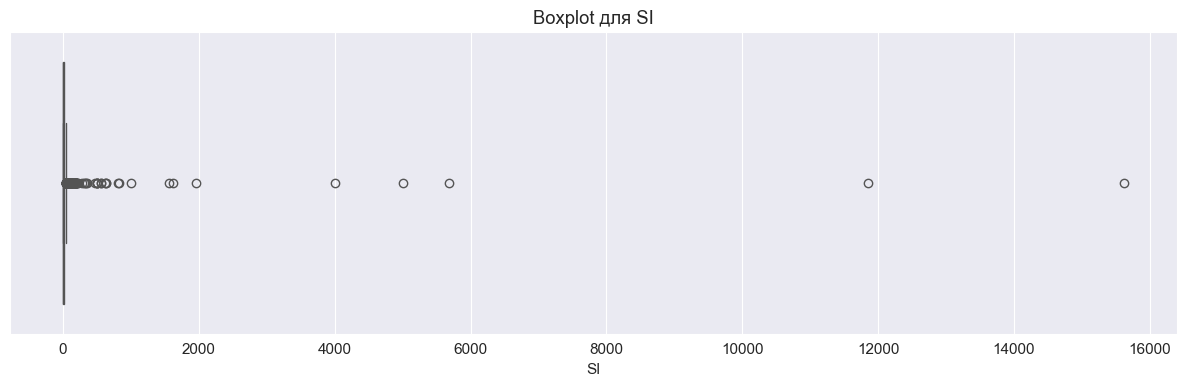

In [3]:
# Строим график для выбросов
plt.figure(figsize=(12, 4))

sns.boxplot(x=df[source_si_variable])

plt.title(f'Boxplot для {source_si_variable}')
plt.tight_layout()
plt.show()

In [4]:
mean = df[source_si_variable].mean()
std = df[source_si_variable].std()
lower_bound = mean - 3 * std
upper_bound = mean + 3 * std

outliers = df[(df[source_si_variable] < lower_bound) | (df[source_si_variable] > upper_bound)]

print("Выбросы по правилу:")
outliers

Выбросы по правилу:


,MaxAbsEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,MaxPartialCharge,MinPartialCharge,FpDensityMorgan1,BCUT2D_MWHI,...,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiophene,fr_unbrch_alkane,fr_urea,"IC50, mM","CC50, mM",SI
102,0.339166,-0.801008,0.583045,-0.034586,0.672790,-0.764201,0.970667,-0.645394,0.560849,-0.464267,...,-0.096976,-0.032191,-0.032191,-0.238522,-0.27518,-0.169643,-0.085436,0.393088,1965.439708,5000.000000
748,0.119444,-0.938375,-0.017240,0.427914,-0.252222,-0.529055,0.730559,-0.913366,1.479895,-0.467427,...,-0.096976,-0.032191,-0.032191,-0.238522,-0.27518,-0.169643,-0.085436,0.003517,19.999437,5687.000000
750,0.119444,-0.938375,-0.017240,0.427914,-0.252222,-0.529055,0.730559,-0.913366,1.479895,-0.467427,...,-0.096976,-0.032191,-0.032191,-0.238522,-0.27518,-0.169643,-0.085436,0.021100,250.001758,11848.333333
772,0.323229,-0.700587,0.343971,0.529446,-0.366018,-0.308884,0.749582,-0.711856,0.915935,-0.465143,...,-0.096976,-0.032191,-0.032191,-0.238522,-0.27518,-0.169643,-0.085436,0.032009,128.090060,4001.700000
775,0.323229,-0.700587,0.343971,0.529446,-0.366018,-0.308884,0.749582,-0.711856,0.915935,-0.465143,...,-0.096976,-0.032191,-0.032191,-0.238522,-0.27518,-0.169643,-0.085436,0.016004,249.999200,15620.600000


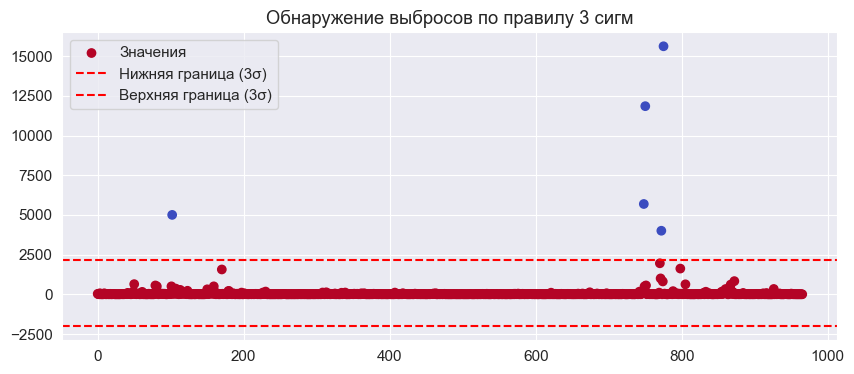

In [5]:
df['is_outlier_3σ'] = (df[source_si_variable] < lower_bound) | (df[source_si_variable] > upper_bound)

plt.figure(figsize=(10, 4))
plt.scatter(df.index, df[source_si_variable], c=~df['is_outlier_3σ'], cmap='coolwarm', label='Значения')
plt.axhline(y=lower_bound, color='r', linestyle='--', label='Нижняя граница (3σ)')
plt.axhline(y=upper_bound, color='r', linestyle='--', label='Верхняя граница (3σ)')
plt.legend()
plt.title('Обнаружение выбросов по правилу 3 сигм')
plt.show()

In [6]:
Q1 = df[source_si_variable].quantile(0.25)
Q3 = df[source_si_variable].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
df["is_outlier_IQR"] = (df[source_si_variable] < lower_bound) | (df[source_si_variable] > upper_bound)
df[(df[source_si_variable] < lower_bound) | (df[source_si_variable] > upper_bound)]

,MaxAbsEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,MaxPartialCharge,MinPartialCharge,FpDensityMorgan1,BCUT2D_MWHI,...,fr_tetrazole,fr_thiazole,fr_thiophene,fr_unbrch_alkane,fr_urea,"IC50, mM","CC50, mM",SI,is_outlier_3σ,is_outlier_IQR
3,-1.762654,1.247702,0.860276,-0.941357,0.988562,0.368166,-1.556297,1.522921,-2.156673,-0.581603,...,-0.032191,-0.238522,-0.27518,3.075405,-0.085436,1.705624,107.855654,63.235294,False,True
9,-1.446717,0.351971,0.763797,-0.650039,0.554459,0.917583,-0.865343,-0.642440,-2.242239,-0.468731,...,-0.032191,-0.238522,-0.27518,-0.169643,-0.085436,6.400847,400.906360,62.633333,False,True
41,-1.763647,1.227715,0.858123,-0.755891,1.073323,0.258081,-1.556297,1.522921,-2.064995,-0.581532,...,-0.032191,-0.238522,-0.27518,2.264143,-0.085436,15.078486,1344.065056,89.137931,False,True
44,-1.762654,1.247702,0.860276,-0.941357,0.988562,0.368166,-1.556297,1.522921,-2.156673,-0.581603,...,-0.032191,-0.238522,-0.27518,3.075405,-0.085436,22.825266,1254.135512,54.945055,False,True
47,-1.758664,1.295320,0.865404,-1.586508,0.639545,0.918595,-1.556297,1.522921,-2.534171,-0.581647,...,-0.032191,-0.238522,-0.27518,7.131714,-0.085436,45.006900,2216.216562,49.241706,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
912,0.598544,0.781167,-0.436645,0.552863,-0.589995,-0.561052,0.857677,-0.425583,-0.587957,-0.451673,...,-0.032191,-0.238522,-0.27518,-0.169643,-0.085436,11.399193,499.994648,43.862285,False,True
916,0.644852,0.736788,-0.442487,0.571027,-0.622508,-0.450966,0.857752,-0.421804,-0.775944,-0.451660,...,-0.032191,-0.238522,-0.27518,-0.169643,-0.085436,6.299480,500.000000,79.371629,False,True
926,-1.639888,1.300933,0.866009,1.533078,0.529893,-0.292842,-0.477621,0.709040,0.163989,0.596023,...,-0.032191,-0.238522,3.63399,-0.169643,-0.085436,0.298932,99.999046,334.521277,False,True
934,1.159558,-0.595294,-0.286326,-1.475986,-1.138048,2.425224,1.332984,-0.795052,-1.104921,-0.287681,...,-0.032191,-0.238522,-0.27518,-0.169643,-0.085436,1.900747,99.999546,52.610669,False,True


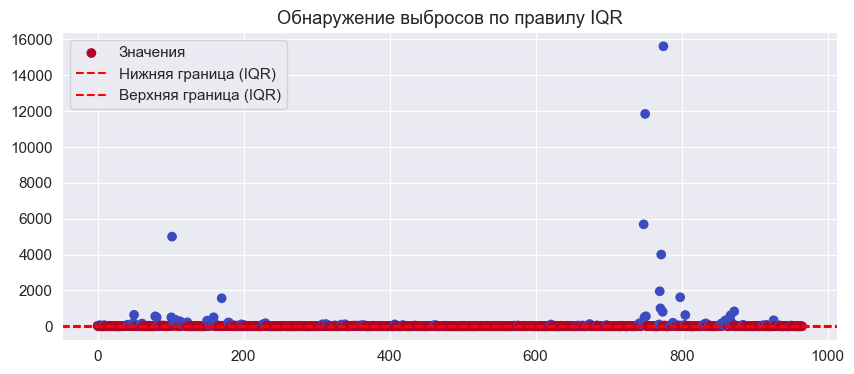

In [7]:
plt.figure(figsize=(10, 4))
plt.scatter(df.index, df[source_si_variable], c=~df['is_outlier_IQR'], cmap='coolwarm', label='Значения')
plt.axhline(y=lower_bound, color='r', linestyle='--', label='Нижняя граница (IQR)')
plt.axhline(y=upper_bound, color='r', linestyle='--', label='Верхняя граница (IQR)')
plt.legend()
plt.title('Обнаружение выбросов по правилу IQR')
plt.show()

In [8]:
df["log_10_SI"] = np.log10(df[source_si_variable])
target_old = source_si_variable
target = "log_10_SI"

In [9]:
mean = df[target].mean()
std = df[target].std()
lower_bound = mean - 3 * std
upper_bound = mean + 3 * std

outliers = df[(df[target] < lower_bound) | (df[target] > upper_bound)]

print("Выбросы по правилу 3 сигм:")
outliers

Выбросы по правилу 3 сигм:


,MaxAbsEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,MaxPartialCharge,MinPartialCharge,FpDensityMorgan1,BCUT2D_MWHI,...,fr_thiazole,fr_thiophene,fr_unbrch_alkane,fr_urea,"IC50, mM","CC50, mM",SI,is_outlier_3σ,is_outlier_IQR,log_10_SI
102,0.339166,-0.801008,0.583045,-0.034586,0.672790,-0.764201,0.970667,-0.645394,0.560849,-0.464267,...,-0.238522,-0.27518,-0.169643,-0.085436,0.393088,1965.439708,5000.000000,True,True,3.698970
170,-1.732992,0.850928,0.817539,1.011016,0.268345,-0.630704,-0.933491,-1.162974,0.239183,-0.469771,...,-0.238522,-0.27518,-0.169643,-0.085436,0.589523,921.129231,1562.500000,False,True,3.193820
735,-1.390456,0.713640,0.802752,-0.076737,2.451767,-1.573665,-1.733732,1.106576,-1.339904,-0.583817,...,-0.238522,-0.27518,-0.169643,-0.085436,60.996734,0.700808,0.011489,False,False,-1.939708
748,0.119444,-0.938375,-0.017240,0.427914,-0.252222,-0.529055,0.730559,-0.913366,1.479895,-0.467427,...,-0.238522,-0.27518,-0.169643,-0.085436,0.003517,19.999437,5687.000000,True,True,3.754883
750,0.119444,-0.938375,-0.017240,0.427914,-0.252222,-0.529055,0.730559,-0.913366,1.479895,-0.467427,...,-0.238522,-0.27518,-0.169643,-0.085436,0.021100,250.001758,11848.333333,True,True,4.073657
764,0.323229,-0.700587,0.343971,0.529446,-0.366018,-0.308884,0.749582,-0.711856,0.915935,-0.465143,...,-0.238522,-0.27518,-0.169643,-0.085436,29.000074,0.800223,0.027594,False,False,-1.559188
770,0.323229,-0.700587,0.343971,0.529446,-0.366018,-0.308884,0.749582,-0.711856,0.915935,-0.465143,...,-0.238522,-0.27518,-0.169643,-0.085436,0.051214,99.999040,1952.562500,False,True,3.290605
771,0.323229,-0.700587,0.343971,0.529446,-0.366018,-0.308884,0.749582,-0.711856,0.915935,-0.465143,...,-0.238522,-0.27518,-0.169643,-0.085436,0.960267,960.267338,1000.000000,False,True,3.000000
772,0.323229,-0.700587,0.343971,0.529446,-0.366018,-0.308884,0.749582,-0.711856,0.915935,-0.465143,...,-0.238522,-0.27518,-0.169643,-0.085436,0.032009,128.090060,4001.700000,True,True,3.602245
775,0.323229,-0.700587,0.343971,0.529446,-0.366018,-0.308884,0.749582,-0.711856,0.915935,-0.465143,...,-0.238522,-0.27518,-0.169643,-0.085436,0.016004,249.999200,15620.600000,True,True,4.193698


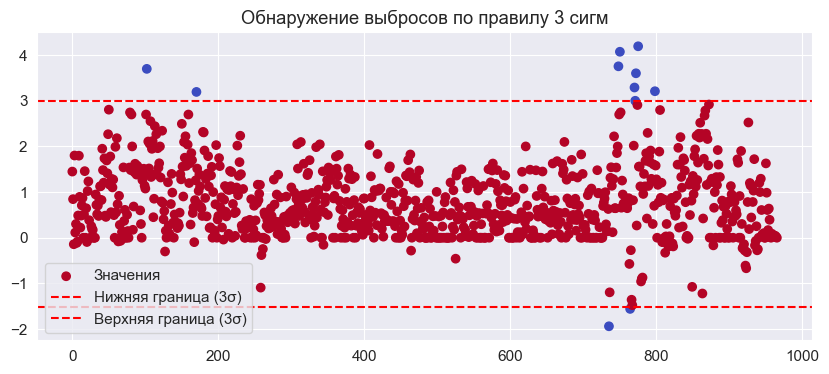

In [10]:
df['is_outlier_3σ'] = (df[target] < lower_bound) | (df[target] > upper_bound)

plt.figure(figsize=(10, 4))
plt.scatter(df.index, df[target], c=~df['is_outlier_3σ'], cmap='coolwarm', label='Значения')
plt.axhline(y=lower_bound, color='r', linestyle='--', label='Нижняя граница (3σ)')
plt.axhline(y=upper_bound, color='r', linestyle='--', label='Верхняя граница (3σ)')
plt.legend()
plt.title('Обнаружение выбросов по правилу 3 сигм')
plt.show()

In [11]:
Q1 = df[target].quantile(0.25)
Q3 = df[target].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
df["is_outlier_IQR"] = (df[target] < lower_bound) | (df[target] > upper_bound)
df[(df[target] < lower_bound) | (df[target] > upper_bound)]

,MaxAbsEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,MaxPartialCharge,MinPartialCharge,FpDensityMorgan1,BCUT2D_MWHI,...,fr_thiazole,fr_thiophene,fr_unbrch_alkane,fr_urea,"IC50, mM","CC50, mM",SI,is_outlier_3σ,is_outlier_IQR,log_10_SI
50,-0.635122,0.032249,0.729359,0.664412,1.022232,-1.227931,-1.369949,0.189156,1.184487,-0.484354,...,-0.238522,-0.27518,-0.169643,-0.085436,3.584101,2288.704450,638.571429,False,True,2.805209
102,0.339166,-0.801008,0.583045,-0.034586,0.672790,-0.764201,0.970667,-0.645394,0.560849,-0.464267,...,-0.238522,-0.27518,-0.169643,-0.085436,0.393088,1965.439708,5000.000000,True,True,3.698970
170,-1.732992,0.850928,0.817539,1.011016,0.268345,-0.630704,-0.933491,-1.162974,0.239183,-0.469771,...,-0.238522,-0.27518,-0.169643,-0.085436,0.589523,921.129231,1562.500000,True,True,3.193820
735,-1.390456,0.713640,0.802752,-0.076737,2.451767,-1.573665,-1.733732,1.106576,-1.339904,-0.583817,...,-0.238522,-0.27518,-0.169643,-0.085436,60.996734,0.700808,0.011489,True,True,-1.939708
748,0.119444,-0.938375,-0.017240,0.427914,-0.252222,-0.529055,0.730559,-0.913366,1.479895,-0.467427,...,-0.238522,-0.27518,-0.169643,-0.085436,0.003517,19.999437,5687.000000,True,True,3.754883
750,0.119444,-0.938375,-0.017240,0.427914,-0.252222,-0.529055,0.730559,-0.913366,1.479895,-0.467427,...,-0.238522,-0.27518,-0.169643,-0.085436,0.021100,250.001758,11848.333333,True,True,4.073657
764,0.323229,-0.700587,0.343971,0.529446,-0.366018,-0.308884,0.749582,-0.711856,0.915935,-0.465143,...,-0.238522,-0.27518,-0.169643,-0.085436,29.000074,0.800223,0.027594,True,True,-1.559188
767,0.323229,-0.700587,0.343971,0.529446,-0.366018,-0.308884,0.749582,-0.711856,0.915935,-0.465143,...,-0.238522,-0.27518,-0.169643,-0.085436,21.001047,0.700995,0.033379,False,True,-1.476526
770,0.323229,-0.700587,0.343971,0.529446,-0.366018,-0.308884,0.749582,-0.711856,0.915935,-0.465143,...,-0.238522,-0.27518,-0.169643,-0.085436,0.051214,99.999040,1952.562500,True,True,3.290605
771,0.323229,-0.700587,0.343971,0.529446,-0.366018,-0.308884,0.749582,-0.711856,0.915935,-0.465143,...,-0.238522,-0.27518,-0.169643,-0.085436,0.960267,960.267338,1000.000000,True,True,3.000000


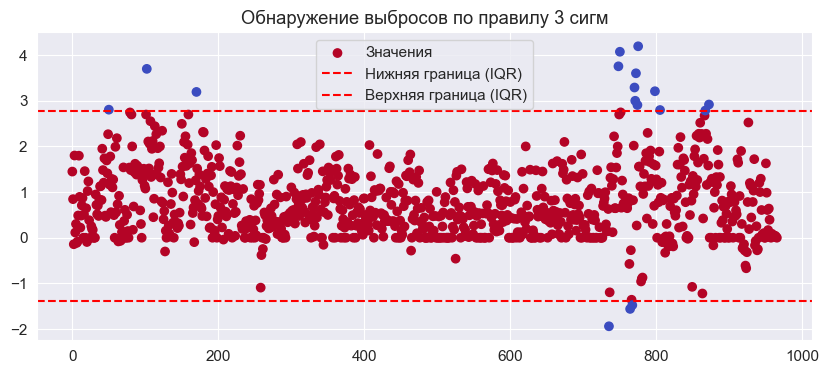

In [12]:
plt.figure(figsize=(10, 4))
plt.scatter(df.index, df[target], c=~df['is_outlier_IQR'], cmap='coolwarm', label='Значения')
plt.axhline(y=lower_bound, color='r', linestyle='--', label='Нижняя граница (IQR)')
plt.axhline(y=upper_bound, color='r', linestyle='--', label='Верхняя граница (IQR)')
plt.legend()
plt.title('Обнаружение выбросов по правилу 3 сигм')
plt.show()

In [13]:
# data_cleaned_IQR = df[~df['is_outlier_IQR']].drop(columns=['is_outlier_IQR', 'is_outlier_3σ'])
data_cleaned_IQR = df[~df['is_outlier_3σ']].drop(columns=['is_outlier_IQR', 'is_outlier_3σ', target_old])

data_cleaned_IQR


,MaxAbsEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,MaxPartialCharge,MinPartialCharge,FpDensityMorgan1,BCUT2D_MWHI,...,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiophene,fr_unbrch_alkane,fr_urea,"IC50, mM","CC50, mM",log_10_SI
0,-1.763647,1.227715,0.858123,-0.755891,1.073323,0.258081,-1.556297,1.522921,-2.064995,-0.581532,...,-0.096976,-0.032191,-0.032191,-0.238522,-0.27518,2.264143,-0.085436,6.239374,175.482382,1.449093
1,-2.108224,2.095440,0.951585,-0.544168,1.254983,0.289724,-1.759553,1.260180,-2.212699,-0.571135,...,-0.096976,-0.032191,-0.032191,-0.238522,-0.27518,2.264143,-0.085436,0.771831,5.402819,0.845098
2,-2.514136,2.150839,0.957552,-1.490120,1.014426,0.745889,-1.118121,1.099403,-2.397328,-0.545366,...,-0.096976,-0.032191,-0.032191,-0.238522,-0.27518,2.264143,-0.085436,223.808778,161.142320,-0.142668
3,-1.762654,1.247702,0.860276,-0.941357,0.988562,0.368166,-1.556297,1.522921,-2.156673,-0.581603,...,-0.096976,-0.032191,-0.032191,-0.238522,-0.27518,3.075405,-0.085436,1.705624,107.855654,1.800960
4,-1.746485,0.536885,0.783714,-0.701088,0.563542,0.902106,-1.367945,2.002451,-2.242239,-0.580930,...,-0.096976,-0.032191,-0.032191,-0.238522,-0.27518,-0.169643,-0.085436,107.131532,139.270991,0.113943
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
961,0.621634,-0.779389,0.307862,-0.918328,1.566453,0.492661,0.628761,-0.790557,-0.036530,-0.461498,...,-0.096976,-0.032191,-0.032191,-0.238522,-0.27518,-0.169643,-0.085436,31.000104,34.999650,0.052701
962,0.834722,-0.884119,0.165598,-0.980878,1.201620,1.050498,0.704502,-0.776102,-0.233468,-0.461496,...,-0.096976,-0.032191,-0.032191,-0.238522,-0.27518,-0.169643,-0.085436,31.999934,33.999415,0.026322
963,0.943127,-0.906571,0.196551,-1.377478,0.997433,1.522336,0.707042,-0.775993,0.065049,0.598260,...,-0.096976,-0.032191,-0.032191,-0.238522,-0.27518,-0.169643,-0.085436,30.999883,33.999458,0.040112
964,0.893994,-0.196583,-0.286468,-0.923926,0.761096,1.340989,0.586631,-0.792770,-1.593940,-0.464683,...,-0.096976,-0.032191,-0.032191,-0.238522,-0.27518,-0.169643,-0.085436,31.998959,32.999644,0.013373


In [14]:
X = data_cleaned_IQR[data_cleaned_IQR.columns[:-3]]
y_ic50 = data_cleaned_IQR[target]


In [15]:
X_train, X_test, y_train_ic50, y_test_ic50 = train_test_split(
    X, y_ic50, test_size=0.2, random_state=42
)


In [16]:
print(f"Размер обучающей выборки: {len(X_train)}")
print(f"Размер тестовой выборки: {len(X_test)}")


Размер обучающей выборки: 764
Размер тестовой выборки: 191


In [17]:
# Метрики
metrics = {
    'R2': r2_score,
    'RMSE': lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred)),
    'MAE': mean_absolute_error
}

# Модели и их гиперпараметры
MODELS = {
    'ridge': {
        'model': Ridge(random_state=112),
        'params': {
            'alpha': [0.01, 0.1, 1, 10, 100],
            'solver': ['auto', 'svd', 'cholesky']
        }
    },
    'rf': {
        'model': RandomForestRegressor(random_state=121),
        'params': {
            'n_estimators': [100, 200],
            'max_depth': [None, 10, 20],
            'min_samples_split': [2, 5]
        }
    },
    'xgb': {
        'model': XGBRegressor(random_state=111),
        'params': {
            'n_estimators': [100, 200],
            'max_depth': [3, 6],
            'learning_rate': [0.01, 0.1]
        }
    }
}

results = []

# Сразу ищем лучшую модель и лучшие результаты с подбором гипперпараметров
for name, config in MODELS.items():
    print(f"\nGridSearchCV для модели: {name}")

    grid = GridSearchCV(
        estimator=config['model'],
        param_grid=config['params'],
        cv=5,
        scoring='r2',
        n_jobs=-1,
        verbose=1
    )
    grid.fit(X_train, y_train_ic50)

    best_model = grid.best_estimator_

    y_pred = best_model.predict(X_test)

    # Метрики
    model_metrics = {}
    for metric_name, metric_func in metrics.items():
        model_metrics[metric_name] = metric_func(y_test_ic50, y_pred)

    results.append({
        'model_name': name,
        'model': best_model,  # Сохраняем саму модель
        'best_params': grid.best_params_,
        'cv_mean_r2': grid.best_score_,
        **model_metrics
    })

# Вывод результатов
results_df = pd.DataFrame(results)
results_df



GridSearchCV для модели: ridge
Fitting 5 folds for each of 15 candidates, totalling 75 fits

GridSearchCV для модели: rf
Fitting 5 folds for each of 12 candidates, totalling 60 fits

GridSearchCV для модели: xgb
Fitting 5 folds for each of 8 candidates, totalling 40 fits


,model_name,model,best_params,cv_mean_r2,R2,RMSE,MAE
0,ridge,"Ridge(alpha=100, random_state=112, solver='svd')","{'alpha': 100, 'solver': 'svd'}",0.102540,0.162995,0.632874,0.488803
1,rf,"(DecisionTreeRegressor(max_depth=10, max_featu...","{'max_depth': 10, 'min_samples_split': 5, 'n_e...",0.147478,0.352413,0.556676,0.425725
2,xgb,"XGBRegressor(base_score=None, booster=None, ca...","{'learning_rate': 0.01, 'max_depth': 3, 'n_est...",0.142268,0.296755,0.580105,0.455185


Лучшей моделью является RandomForestRegressor (rf), потому что:

1. У неё лучшее качество на тесте по R²: 0.35
2. Также наименьшие ошибки RMSE и MAE.
3. Хотя xgb и rf близки по cv_mean_r2, rf лучше обобщает на тесте